# Speed dating experiment

## What influences love at first sight? Or, at least, love in the first four minutes?

The [dataset](https://www.kaggle.com/annavictoria/speed-dating-experiment) was compiled by Columbia Business School professors Ray Fisman and Sheena Iyengar for their paper *Gender Differences in Mate Selection: Evidence From a Speed Dating Experiment*.

Data was gathered from participants in experimental speed dating events from 2002-2004. During the events, the attendees would have a four minute "first date" with every other participant of the opposite sex. At the end of their four minutes, participants were asked if they would like to see their date again. They were also asked to rate their date on six attributes: Attractiveness, Sincerity, Intelligence, Fun, Ambition, and Shared Interests.

## Setup

In [55]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [56]:
# Hiding warnings for better appearance (this was added after checking all warnings)
import warnings
warnings.filterwarnings(action = "ignore")

### Style

In [57]:
blue = '#1e1eff'
purple = '#7c7bfb'
salmon = '#ff9696'
red = '#ff5a5a'
pie_chart_colors = [red, blue]
cmap = sns.color_palette("vlag", as_cmap=True)

In [58]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Loading data

In [59]:
data = pd.read_csv('dataset.csv')
data = data.drop(columns=['Unnamed: 0'])

## Hypothesis evaluation

Hypothesis 1 - It is possible to predict participants' match based on their personal characteristics and interests.

Hypothesis 2 - It is possible to predict how much the participant likes their date and which attributes have the biggest influence on it based on the date participants' personal characteristics.

Hypothesis 3 - It is possible to predict participant's preference on partner's intelligence based on the participant's personal characteristics.

Hypothesis 4 - It is true that techinal eingineers tend to date medics.

Hypothesis 5 - It is true that sports oriented women are looking for sports oriented men.

### Hypothesis 1
It is possible to predict participants' match based on their personal characteristics and interests.

In [53]:
data_1 = data.copy()

data_1 = data_1[[
    'match',
    'samerace',
    'int_corr',
    'attr_me', 'sinc_me', 'fun_me', 'intel_me', 'amb_me',
    'attr_me_partners', 'sinc_me_partners', 'fun_me_partners', 'intel_me_partners', 'amb_me_partners'
]].dropna()


data_x = data_1.drop(columns=['match'])
data_y = data_1['match']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, random_state=42 )

In [55]:
data_x

,samerace,int_corr,attr_me,sinc_me,fun_me,intel_me,amb_me,attr_me_partners,sinc_me_partners,fun_me_partners,intel_me_partners,amb_me_partners
0,0,0.14,6.0,8.0,8.0,8.0,7.0,8.0,9.0,7.0,8.0,5.0
1,0,0.54,6.0,8.0,8.0,8.0,7.0,9.0,9.0,9.0,10.0,9.0
2,1,0.16,6.0,8.0,8.0,8.0,7.0,4.0,7.0,8.0,8.0,3.0
3,0,0.61,6.0,8.0,8.0,8.0,7.0,9.0,9.0,9.0,9.0,9.0
4,0,0.21,6.0,8.0,8.0,8.0,7.0,7.0,7.0,7.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8373,0,0.64,8.0,7.0,6.0,7.0,7.0,3.0,6.0,9.0,7.0,10.0
8374,0,0.71,8.0,7.0,6.0,7.0,7.0,10.0,10.0,10.0,10.0,10.0
8375,0,-0.46,8.0,7.0,6.0,7.0,7.0,9.0,6.0,8.0,8.0,8.0
8376,0,0.62,8.0,7.0,6.0,7.0,7.0,6.0,10.0,9.0,7.0,5.0


#### K-NN algorithm

##### Looking for the best number of classes

Text(0, 0.5, 'auc_score')

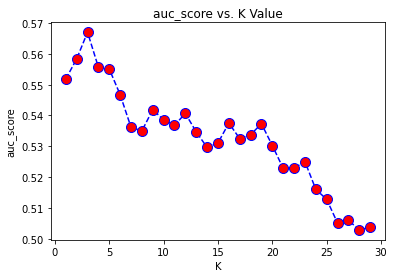

In [66]:
auc_score = []
for i in range(1,30):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict_proba(X_test)
    pred_i = pred_i[:, 1]
    auc_score.append( roc_auc_score(y_test,pred_i) )
    
plt.plot(range(1,30), auc_score, color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('auc_score vs. K Value')
plt.xlabel('K')
plt.ylabel('auc_score')

We see that the best option would have 1 cluster - that doesnt make sense so we will take 3 clusters in further training

In [67]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred_i = knn.predict(X_test)

print(f'Area under ROC curve is {roc_auc_score(y_test,pred_i)}')

Area under ROC curve is 0.5345238784370479


##### ROC curve

In [68]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

def plot_curve(_probs, y_test, model_name):
    _probs = _probs[:, 1]
    ns_probs = [0 for _ in range(len(y_test))]

    # calculate scores
    auc = roc_auc_score(y_test, _probs)
    ns_auc = roc_auc_score(y_test, ns_probs)

    print('Logistic: ROC AUC=%.3f' % (auc))

    # calculate roc curves
    _fpr, _tpr, _ = roc_curve(y_test, _probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

    # plot the roc curve for the model
    plt.plot(_fpr, _tpr, marker='.', label=model_name, color='red')
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.show()

Logistic: ROC AUC=0.567


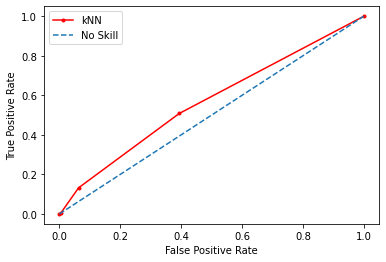

In [69]:
plot_curve(knn.predict_proba(X_test), y_test, 'kNN')

In [70]:
print(f'Silhouette_score is {silhouette_score(X_test,pred_i)}')

Silhouette_score is -0.017570582226659692


##### Confusion matrix

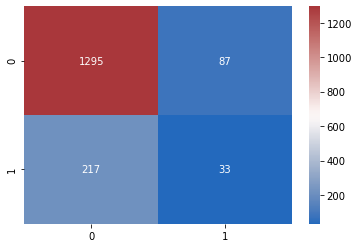

In [16]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred_i))
sns.heatmap(df_cm, annot=True, fmt="d", cmap=cmap)

In [17]:
print(classification_report(y_test, pred_i))

              precision    recall  f1-score   support

           0       0.86      0.94      0.89      1382
           1       0.28      0.13      0.18       250

    accuracy                           0.81      1632
   macro avg       0.57      0.53      0.54      1632
weighted avg       0.77      0.81      0.79      1632



In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_i).ravel()

accuracy = (tp + tn) / (tn + fp + fn + tp)
recall = tp  / (fn + tp)
precision = tp / (fp + tp)
f1_score = (2*recall*precision) / (precision + recall)
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)

print(f'Accuracy: {round(accuracy*100,2)}%')
print(f'Recall: {round(recall*100,2)}%')
print(f'Precision: {round(precision*100,2)}%')
print(f'F1_score: {round(f1_score*100,2)}%')
print(f'Specificity: {round(specificity*100,2)}%')
print(f'Sensitivity: {round(sensitivity*100,2)}%')

##### Cross validation

In [15]:
results = []
for i in range(100):
    
    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20 )
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)

    results.append(roc_auc_score(y_test,pred_i))
    

pd.DataFrame(results).describe()    

,0
count,100.000000
mean,0.524459
std,0.009226
min,0.505795
25%,0.517623
50%,0.524239
75%,0.530220
max,0.547097


#### Decision tree

##### Grid search params

In [50]:
criterion = ["gini", "entropy"]

# Number of features to consider at every split
max_features = ["auto", "log2"]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

param_grid = {
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf
}

In [51]:
dtree_model = DecisionTreeClassifier()

dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=5, scoring='roc_auc')
dtree_gscv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                       None],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             scoring='roc_auc')

In [52]:
params = dtree_gscv.best_params_
dtree_best_model = DecisionTreeClassifier(**params)
dtree_best_model.fit(X_train,y_train)
pred_i = dtree_best_model.predict(X_test)

print(f'Area under ROC curve is {roc_auc_score(y_test,pred_i)}')

Area under ROC curve is 0.5295282199710565


Logistic: ROC AUC=0.572


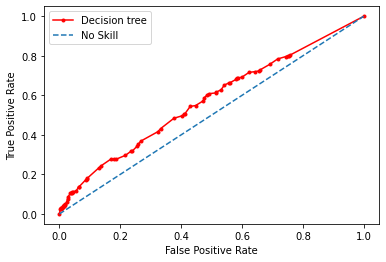

In [53]:
plot_curve(dtree_best_model.predict_proba(X_test), y_test, 'Decision tree')

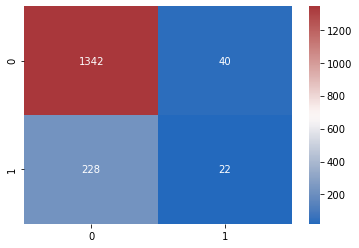

In [54]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred_i))
sns.heatmap(df_cm, annot=True, fmt="d", cmap=cmap)

In [55]:
print(classification_report(y_test,pred_i))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1382
           1       0.35      0.09      0.14       250

    accuracy                           0.84      1632
   macro avg       0.60      0.53      0.53      1632
weighted avg       0.78      0.84      0.79      1632



In [56]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_i).ravel()

accuracy = (tp + tn) / (tn + fp + fn + tp)
recall = tp  / (fn + tp)
precision = tp / (fp + tp)
f1_score = (2*recall*precision) / (precision + recall)
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)

print(f'Accuracy: {round(accuracy*100,2)}%')
print(f'Recall: {round(recall*100,2)}%')
print(f'Precision: {round(precision*100,2)}%')
print(f'F1_score: {round(f1_score*100,2)}%')
print(f'Specificity: {round(specificity*100,2)}%')
print(f'Sensitivity: {round(sensitivity*100,2)}%')

Accuracy: 83.58%
Recall: 8.8%
Precision: 35.48%
F1_score: 14.1%
Specificity: 97.11%
Sensitivity: 8.8%


### With hobbies

In [7]:
data_1 = data.copy()

data_1 = data_1[[
    'match',
    'samerace',
    'int_corr',
    'attr_me', 'sinc_me', 'fun_me', 'intel_me', 'amb_me',
    'attr_me_partners', 'sinc_me_partners', 'fun_me_partners', 'intel_me_partners', 'amb_me_partners',
    
    'sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
    'reading','tv','theater','movies','concerts','music','shopping','yoga',
    
    'sports_partners','tvsports_partners','exercise_partners','dining_partners','museums_partners','art_partners','hiking_partners',
    'gaming_partners','clubbing_partners',
    'reading_partners','tv_partners','theater_partners','movies_partners','concerts_partners',
    'music_partners','shopping_partners','yoga_partners',
    
]].dropna()


data_x = data_1.drop(columns=['match'])
data_y = data_1['match']

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, random_state=42)

##### Looking for the best number of classes

In [8]:
auc_score = []

for i in range(1,30):    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    #pred_i = pred_i[:, 1]
#     print(pred_i)
#     print(y_test)
    
#     print(f1_score(y_test,pred_i))
    auc_score.append( f1_score(y_test,pred_i) )
    
plt.plot(range(1,30),auc_score,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('auc_score vs. K Value')
plt.xlabel('K')
plt.ylabel('auc_score')

KeyboardInterrupt: 

In [87]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred_i = knn.predict(X_test)

print(f'Area under ROC curve is {roc_auc_score(y_test,pred_i)}')

Area under ROC curve is 0.522917510853835


##### ROC curve

Logistic: ROC AUC=0.609


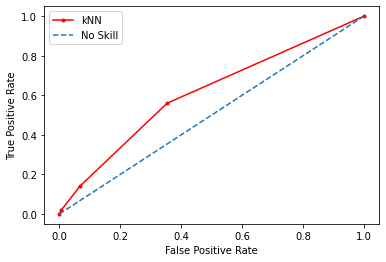

In [39]:
plot_curve(knn.predict_proba(X_test), y_test, 'kNN')

In [40]:
print(f'Silhouette_score is {silhouette_score(X_test,pred_i)}')

Silhouette_score is 0.0015311996462809743


##### Confusion matrix

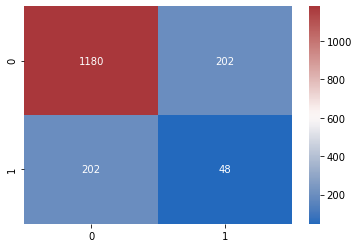

In [88]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred_i))
sns.heatmap(df_cm, annot=True, fmt="d", cmap=cmap)

In [89]:
print(classification_report(y_test, pred_i))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1382
           1       0.19      0.19      0.19       250

    accuracy                           0.75      1632
   macro avg       0.52      0.52      0.52      1632
weighted avg       0.75      0.75      0.75      1632



In [90]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_i).ravel()

accuracy = (tp + tn) / (tn + fp + fn + tp)
recall = tp  / (fn + tp)
precision = tp / (fp + tp)
f1_score = (2*recall*precision) / (precision + recall)
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)

print(f'Accuracy: {round(accuracy*100,2)}%')
print(f'Recall: {round(recall*100,2)}%')
print(f'Precision: {round(precision*100,2)}%')
print(f'F1_score: {round(f1_score*100,2)}%')
print(f'Specificity: {round(specificity*100,2)}%')
print(f'Sensitivity: {round(sensitivity*100,2)}%')

Accuracy: 75.25%
Recall: 19.2%
Precision: 19.2%
F1_score: 19.2%
Specificity: 85.38%
Sensitivity: 19.2%


#### Decision tree

##### Grid search params

In [58]:
dtree_model = DecisionTreeClassifier()

dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=5, scoring='roc_auc')
dtree_gscv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                       None],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             scoring='roc_auc')

In [59]:
params = dtree_gscv.best_params_
dtree_best_model = DecisionTreeClassifier(**params)
dtree_best_model.fit(X_train,y_train)
pred_i = dtree_best_model.predict(X_test)

print(f'Area under ROC curve is {roc_auc_score(y_test,pred_i)}')

Area under ROC curve is 0.5229753979739509


Logistic: ROC AUC=0.569


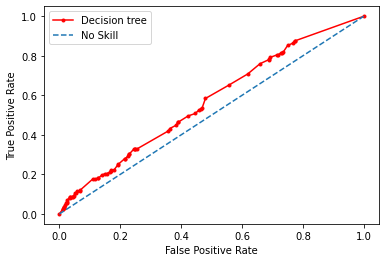

In [60]:
plot_curve(dtree_best_model.predict_proba(X_test), y_test, 'Decision tree')

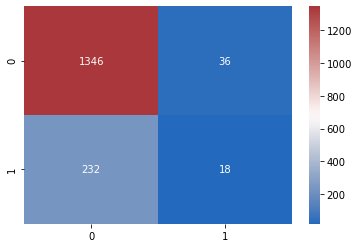

In [61]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred_i))
sns.heatmap(df_cm, annot=True, fmt="d", cmap=cmap)

In [62]:
print(classification_report(y_test,pred_i))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1382
           1       0.33      0.07      0.12       250

    accuracy                           0.84      1632
   macro avg       0.59      0.52      0.51      1632
weighted avg       0.77      0.84      0.79      1632



In [63]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_i).ravel()

accuracy = (tp + tn) / (tn + fp + fn + tp)
recall = tp  / (fn + tp)
precision = tp / (fp + tp)
f1_score = (2*recall*precision) / (precision + recall)
specificity = tn / (tn+fp)
sensitivity = tp / (tp + fn)

print(f'Accuracy: {round(accuracy*100,2)}%')
print(f'Recall: {round(recall*100,2)}%')
print(f'Precision: {round(precision*100,2)}%')
print(f'F1_score: {round(f1_score*100,2)}%')
print(f'Specificity: {round(specificity*100,2)}%')
print(f'Sensitivity: {round(sensitivity*100,2)}%')

Accuracy: 83.58%
Recall: 7.2%
Precision: 33.33%
F1_score: 11.84%
Specificity: 97.4%
Sensitivity: 7.2%


### Hypothesis 2
It is possible to predict how much the participant likes their date and which attributes have the biggest influence on it based on the date participants' personal characteristics.

In [27]:
data_3 = data.copy()

data_3 = data_3[[
    'attr_me_partners', 'sinc_me_partners', 'fun_me_partners', 'intel_me_partners', 'amb_me_partners',
    'iid_like_pid'
   
]].dropna()

In [28]:
data_x = data_3.drop(columns="iid_like_pid")
data_y = data_3['iid_like_pid']

#### Is there a relationship between predicted variable and features ?

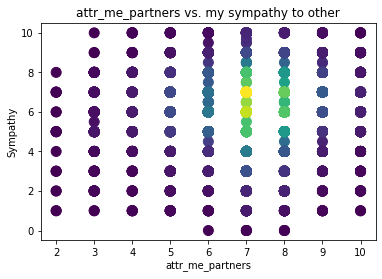

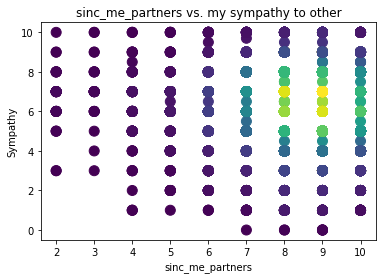

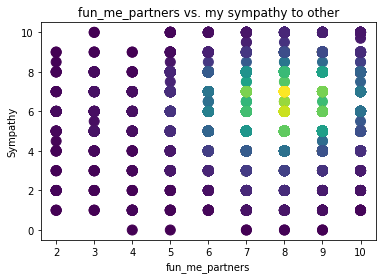

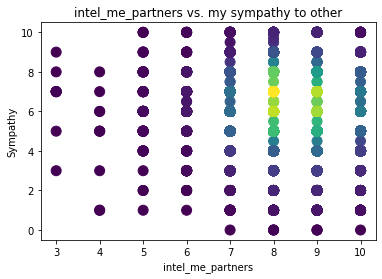

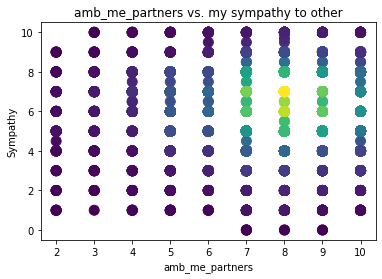

In [29]:
for attr in ['attr_me_partners', 'sinc_me_partners', 'fun_me_partners', 'intel_me_partners', 'amb_me_partners']:
    x = data_x[attr]
    y = data_y

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=100)
    plt.title(attr + ' vs. my sympathy to other')
    plt.xlabel(attr)
    plt.ylabel('Sympathy')
    plt.show()

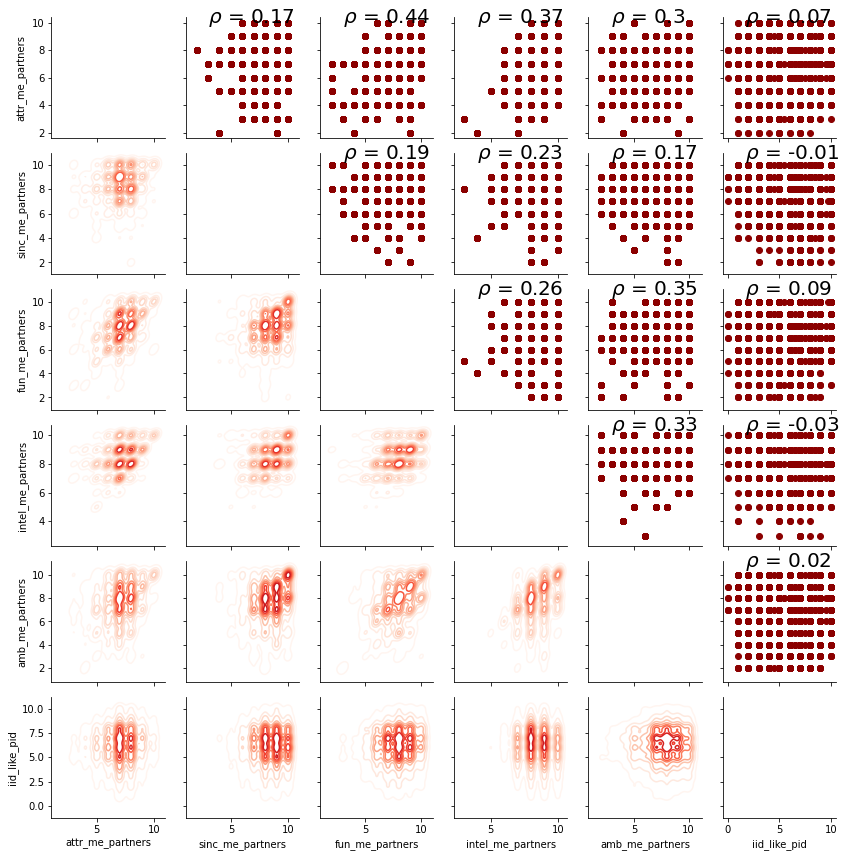

In [56]:
from scipy.stats import pearsonr
def corr(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]

    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)

# Create a pair grid instance
grid = sns.PairGrid(data= data_3,
                    vars = [
                            'attr_me_partners', 'sinc_me_partners', 'fun_me_partners', 'intel_me_partners', 'amb_me_partners',
    'iid_like_pid'
                           ], size = 2)

# Map the plots to the locations
grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = 'darkred');

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, random_state=42 )

In [48]:
X_train_bias = sm.add_constant(X_train)
X_test_bias = sm.add_constant(X_test)

gamma_model = sm.GLM(y_train,X_train_bias, family=sm.families.Poisson())

gamma_results = gamma_model.fit()

print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           iid_like_pid   No. Observations:                 6425
Model:                            GLM   Df Residuals:                     6419
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13579.
Date:                Thu, 31 Mar 2022   Deviance:                       3900.0
Time:                        16:33:36   Pearson chi2:                 3.48e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7875      0.04

In [49]:
y_pred = gamma_results.predict(X_test_bias)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mse)

In [50]:
print(rmse)

1.8655988092397024


In [34]:
df_pred = X_train[['attr_me_partners', 'sinc_me_partners', 'fun_me_partners', 'intel_me_partners', 'amb_me_partners']]

#### Are there any error, outliers, specific points... - NO

In [35]:
df_pred.describe()

,attr_me_partners,sinc_me_partners,fun_me_partners,intel_me_partners,amb_me_partners
count,6425.000000,6425.000000,6425.000000,6425.000000,6425.000000
mean,7.085603,8.299455,7.700389,8.409805,7.587704
std,1.399103,1.415635,1.569193,1.080074,1.785546
min,2.000000,2.000000,2.000000,3.000000,2.000000
25%,6.000000,8.000000,7.000000,8.000000,7.000000
50%,7.000000,8.000000,8.000000,8.000000,8.000000
75%,8.000000,9.000000,9.000000,9.000000,9.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000


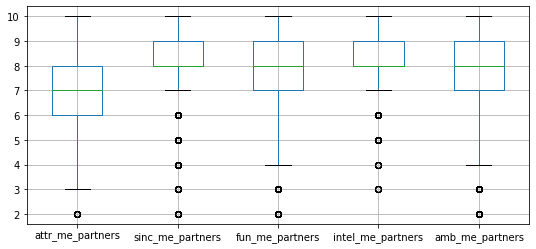

In [36]:
df_pred.boxplot(figsize=(9,4))

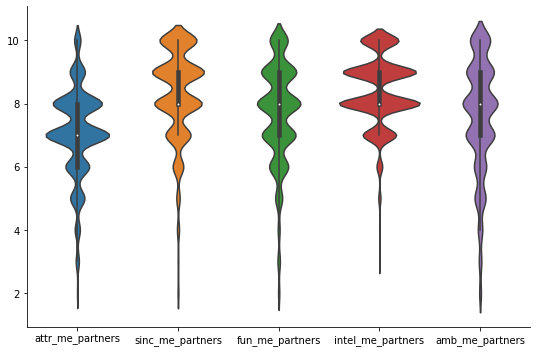

In [37]:
g = sns.catplot( kind="violin", data=df_pred)
g.fig.set_figwidth(8.27)

#### Evaluation

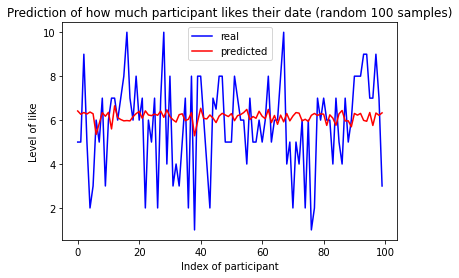

In [38]:
df_ = pd.DataFrame({'real_like': np.array(y_test), 'predicted_like': np.array(y_pred)})

plt.plot(np.array(df_['real_like'][:100]), color = 'blue', label = 'real')
plt.plot(np.array(df_['predicted_like'][:100]), color = 'red', label = 'predicted')
plt.title('Prediction of how much participant likes their date (random 100 samples)')
plt.xlabel('Index of participant')
plt.ylabel('Level of like')
plt.legend()
plt.show()

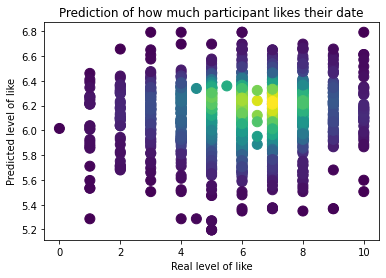

In [39]:
x = y_test
y = y_pred

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)

plt.title('Prediction of how much participant likes their date')
plt.xlabel('Real level of like')
plt.ylabel('Predicted level of like')
plt.show()

### Hypothesis 3

It is possible to predict participant's preference on partner's intelligence based on the participant's personal characteristics.

In [35]:
data_2 = data.copy()

In [36]:
df_personal = data_2[[
  'attr_me', 'sinc_me', 'fun_me', 'intel_me', 'amb_me', 'iid', 'pid', 'match', 'intel_me_partners', 'dec', 'dec_partner',
    'career','career_c'
]]

In [37]:
df_personal = df_personal[df_personal['match']==1]

df_personal.dropna(inplace=True)

df_personal_y = df_personal['intel_me_partners']
df_personal_x = df_personal.drop(columns=['intel_me_partners'])

#### Is there realtionship between our features and predicted value ?

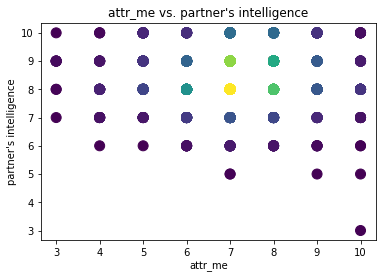

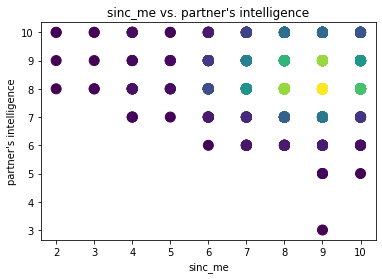

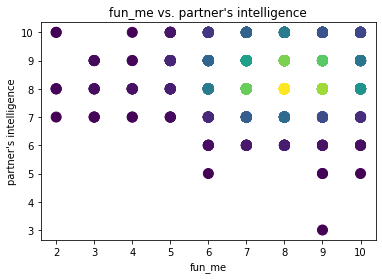

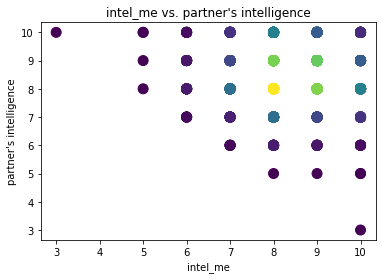

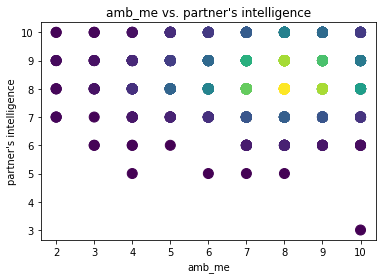

In [38]:
for attr in df_personal.columns[:5]:
    x = df_personal[attr]
    y = df_personal['intel_me_partners']

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=100)
    plt.title(attr + ' vs. partner\'s intelligence')
    plt.xlabel(attr)
    plt.ylabel('partner\'s intelligence')
    plt.show()

#### Poisson regression

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_personal_x, df_personal_y, test_size=0.20, random_state=42 )

In [40]:
X_train[['attr_me','intel_me','sinc_me','amb_me']].describe()

,attr_me,intel_me,sinc_me,amb_me
count,1052.000000,1052.000000,1052.000000,1052.000000
mean,7.199620,8.405894,8.270913,7.623574
std,1.360752,1.012615,1.414143,1.684127
min,3.000000,3.000000,2.000000,2.000000
25%,6.000000,8.000000,8.000000,7.000000
50%,7.000000,8.000000,8.000000,8.000000
75%,8.000000,9.000000,9.000000,9.000000
max,10.000000,10.000000,10.000000,10.000000


Almost all of our data have mean around 7-8 and variance logicly must be lower, because we have data in scale 1-10. As we can see in the table above, variances are about 1-2. Poissonal data should have equal mean and variance, thats something that is unreal in our case.

In [45]:
X_train_bias = sm.add_constant(X_train[['attr_me','intel_me','sinc_me','amb_me']])
X_test_bias = sm.add_constant(X_test[['attr_me','intel_me','sinc_me','amb_me']])

gamma_model = sm.GLM(y_train,X_train_bias, family=sm.families.Poisson())

gamma_results = gamma_model.fit()

print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      intel_me_partners   No. Observations:                 1052
Model:                            GLM   Df Residuals:                     1047
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2159.1
Date:                Fri, 01 Apr 2022   Deviance:                       131.50
Time:                        09:42:50   Pearson chi2:                     128.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2069      0.100     22.164      0.0

In [46]:
y_pred = gamma_results.predict(X_test_bias)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mse)

print(rmse)

1.0176467294113558


#### Negative Binomial regression

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df_personal_x, df_personal_y, test_size=0.20, random_state=42 )

In [47]:
X_train_bias = sm.add_constant(X_train[['attr_me','intel_me','sinc_me','amb_me']])
X_test_bias = sm.add_constant(X_test[['attr_me','intel_me','sinc_me','amb_me']])

gamma_model = sm.GLM(y_train,X_train_bias, family=sm.families.NegativeBinomial())

gamma_results = gamma_model.fit()

print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      intel_me_partners   No. Observations:                 1052
Model:                            GLM   Df Residuals:                     1047
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3352.5
Date:                Fri, 01 Apr 2022   Deviance:                       14.441
Time:                        09:43:19   Pearson chi2:                     13.6
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2063      0.306      7.206      0.0

In [49]:
y_pred = gamma_results.predict(X_test_bias)

mse = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(mse)

print(rmse)

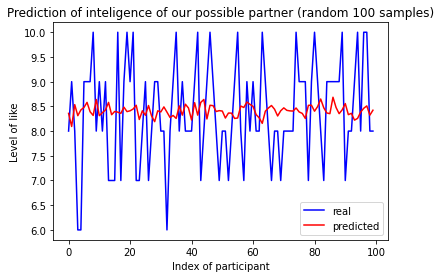

In [54]:
df_ = pd.DataFrame({'real_like': np.array(y_test), 'predicted_like': np.array(y_pred)})

plt.plot(np.array(df_['real_like'][:100]), color = 'blue', label = 'real')
plt.plot(np.array(df_['predicted_like'][:100]), color = 'red', label = 'predicted')
plt.title('Prediction of inteligence of our possible partner (random 100 samples)')
plt.xlabel('Index of participant')
plt.ylabel('Level of like')
plt.legend()
plt.show()

#### Are there any error, outliers, specific points... - NO

In [51]:
df_pred = X_train[['attr_me','intel_me','sinc_me','amb_me']]

In [52]:
df_pred.describe()

,attr_me,intel_me,sinc_me,amb_me
count,1052.000000,1052.000000,1052.000000,1052.000000
mean,7.199620,8.405894,8.270913,7.623574
std,1.360752,1.012615,1.414143,1.684127
min,3.000000,3.000000,2.000000,2.000000
25%,6.000000,8.000000,8.000000,7.000000
50%,7.000000,8.000000,8.000000,8.000000
75%,8.000000,9.000000,9.000000,9.000000
max,10.000000,10.000000,10.000000,10.000000


<AxesSubplot:>

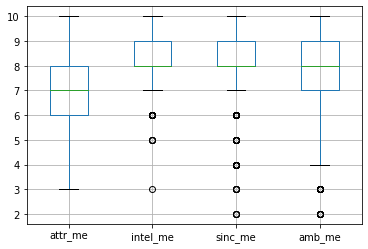

In [62]:
df_pred.boxplot()

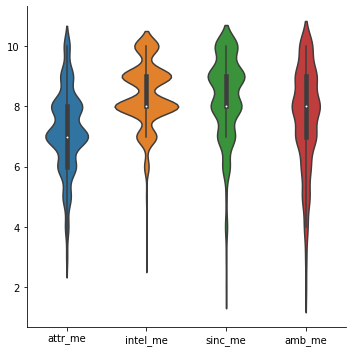

In [63]:
sns.catplot( kind="violin", data=df_pred)

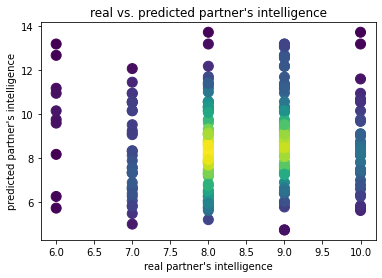

In [64]:
x = y_test
y = y_pred

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)

plt.title('real vs. predicted partner\'s intelligence')
plt.xlabel('real partner\'s intelligence')
plt.ylabel('predicted partner\'s intelligence')
plt.show()

### Hypothesis 4
It is true that techinal eingineers tend to date medics.

In [6]:
enc = OneHotEncoder()

#### Model formalism

In [7]:
data_4 = data.copy()

In [8]:
df_personal = data_4[[
   'iid', 'pid', 'match', 'dec', 'career_c', 'career_c_partners', 'gender', 'gender_partners'
]]
df_personal.dropna(inplace=True)

In [9]:
enc_df_partners = pd.DataFrame(enc.fit_transform(df_personal[['career_c_partners']]).toarray())
enc_df_partners = enc_df_partners.add_suffix('_partners')

enc_df_me = pd.DataFrame(enc.fit_transform(df_personal[['career_c']]).toarray())
enc_df_me = enc_df_me.add_suffix('_me')

In [10]:
df_personal = df_personal.join(enc_df_partners,lsuffix='_partners')
df_personal = df_personal.join(enc_df_me,rsuffix='_me')

#### Eingineers & Medics

In [11]:
df_match = df_personal[ df_personal['match']==1 ]
df_match.dropna(inplace=True)

In [12]:
df_match.columns

Index(['iid', 'pid', 'match', 'dec', 'career_c', 'career_c_partners', 'gender',
       'gender_partners', '0_partners', '1_partners', '2_partners',
       '3_partners', '4_partners', '5_partners', '6_partners', '7_partners',
       '8_partners', '9_partners', '10_partners', '11_partners', '12_partners',
       '13_partners', '14_partners', '15_partners', '16_partners', '0_me',
       '1_me', '2_me', '3_me', '4_me', '5_me', '6_me', '7_me', '8_me', '9_me',
       '10_me', '11_me', '12_me', '13_me', '14_me', '15_me', '16_me'],
      dtype='object')

In [13]:
df_match = df_match.rename(columns={
    '0_partners' : 'lawyer',
    '1_partners' : 'academic',
    '2_partners' : 'psychologist',
    '3_partners' : 'doctor',
    '4_partners' : 'engineer',
    '5_partners' : 'entertainment',
    '6_partners' : 'bussiness',
    '7_partners' : 'real estate',
    '8_partners' : 'international',
    '9_partners' : 'undecided',
    '10_partners' : 'social work',
    '11_partners' : 'speach',
    '12_partners' : 'politics',
    '13_partners' : 'athletics',
    '14_partners' : 'other',
    '15_partners' : 'journalism',
    '16_partners' : 'architecture'
})

df_match = df_match.rename(columns={
    '3_me' : 'doctor_me',
    '4_me' : 'engineer_me',

})

In [14]:
atrs_partners = ['lawyer', 'academic', 'psychologist',
       'doctor', 
        'engineer', 'entertainment',
        'bussiness', 'real estate',
       'international', 'undecided', 'social work', 'speach', 'politics',
       'athletics', 'other', 'journalism', 'architecture'
]

atrs = [
        #'0_me','1_me', '2_me', '3_me',
        'doctor_me',
        'engineer_me'
        #'6_me', '7_me', '8_me', '9_me',
        #'10_me', '11_me', '12_me', '13_me', '14_me', '15_me'
]

In [15]:
df_match.columns

Index(['iid', 'pid', 'match', 'dec', 'career_c', 'career_c_partners', 'gender',
       'gender_partners', 'lawyer', 'academic', 'psychologist', 'doctor',
       'engineer', 'entertainment', 'bussiness', 'real estate',
       'international', 'undecided', 'social work', 'speach', 'politics',
       'athletics', 'other', 'journalism', 'architecture', '0_me', '1_me',
       '2_me', 'doctor_me', 'engineer_me', '5_me', '6_me', '7_me', '8_me',
       '9_me', '10_me', '11_me', '12_me', '13_me', '14_me', '15_me', '16_me'],
      dtype='object')

In [17]:
# https://stats.stackexchange.com/questions/463324/logistic-regression-failed-in-statsmodel-but-works-in-sklearn-breast-cancer-dat

def calc_logit_carrer(df_match, x_vars, y_var):
    
    
    X_train_bias = sm.add_constant(df_match[x_vars])


    logit_mod = sm.GLM( df_match[y_var], X_train_bias, family=sm.families.NegativeBinomial()).fit()

    print(logit_mod.summary())

In [18]:
for i in atrs:
    print(i)
    x_vars = atrs_partners.copy()
    
    calc_logit_carrer(df_match.copy(), x_vars, i )

doctor_me


ValueError: NaN, inf or invalid value detected in weights, estimation infeasible.

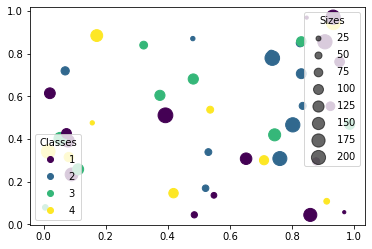

In [77]:
N = 45
x, y = np.random.rand(2, N)
c = np.random.randint(1, 5, size=N)
s = np.random.randint(10, 220, size=N)

fig, ax = plt.subplots()

scatter = ax.scatter(x, y, c=c, s=s)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")

plt.show()

### Hypothesis 5
It is true that sports oriented women are looking for sports oriented men.

In [60]:
data_4 = data.copy()

In [61]:
df_personal = data_4[[
  'attr_me', 'sinc_me', 'fun_me', 'intel_me', 'amb_me', 'iid', 'pid', 'match', 'intel_me_partners', 'dec', 'dec_partner',
    'career','career_c', 'career_c_partners', 'gender', 'gender_partners',
    
    'sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
    'reading','tv','theater','movies','concerts','music','shopping','yoga',
    
    'sports_partners','tvsports_partners','exercise_partners','dining_partners','museums_partners','art_partners','hiking_partners',
    'gaming_partners','clubbing_partners',
    'reading_partners','tv_partners','theater_partners','movies_partners','concerts_partners',
    'music_partners','shopping_partners','yoga_partners',
    
    
]]

colls = [
    'sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
    'reading','tv','theater','movies','concerts','music','shopping','yoga',
    
    'sports_partners','tvsports_partners','exercise_partners','dining_partners','museums_partners','art_partners','hiking_partners',
    'gaming_partners','clubbing_partners',
    'reading_partners','tv_partners','theater_partners','movies_partners','concerts_partners',
    'music_partners','shopping_partners','yoga_partners'
]

In [62]:
atrs = [
    'sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
    'reading','tv','theater','movies','concerts','music','shopping','yoga'
]

atrs_partners = [
    'sports_partners','tvsports_partners','exercise_partners','dining_partners',
    'museums_partners','art_partners','hiking_partners','gaming_partners','clubbing_partners',
    'reading_partners','tv_partners','theater_partners','movies_partners','concerts_partners',
    'music_partners','shopping_partners','yoga_partners'
]

for i in atrs:
    
    mean_i = df_personal[i].mean()
    df_personal[i] = df_personal[i] > mean_i
    df_personal[i+'_partners'] = df_personal[i+'_partners'] > mean_i

df_personal = df_personal.replace({True:1,False:0})

In [71]:
def calc_logit(df_match, x_vars, y_var ):
    
    
    X_train_bias = sm.add_constant(df_match[x_vars])
    Y_train = df_match[y_var]
    
    X_train, X_test, y_train, y_test = train_test_split(X_train_bias, Y_train, test_size=0.10, random_state=42 )
    
    logit_mod = sm.Logit( y_train, X_train )

    logit_res = logit_mod.fit()
    
    y_pred = logit_res.predict(X_test)
    
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = (tp + tn) / (tn + fp + fn + tp)
    recall = tp  / (fn + tp)
    precision = tp / (fp + tp)
    f1_score = (2*recall*precision) / (precision + recall)
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp + fn)

    print(f'Accuracy: {round(accuracy*100,2)}%')
    print(f'Recall: {round(recall*100,2)}%')
    print(f'Precision: {round(precision*100,2)}%')
    print(f'F1_score: {round(f1_score*100,2)}%')
    print(f'Specificity: {round(specificity*100,2)}%')
    print(f'Sensitivity: {round(sensitivity*100,2)}%')

In [72]:
for i in atrs:
    print(i)

    x_vars = atrs_partners.copy()
    
    calc_logit(df_personal.copy(), x_vars, i )

sports
Optimization terminated successfully.
         Current function value: 0.679975
         Iterations 4
Accuracy: 54.06%
Recall: 78.65%
Precision: 54.69%
F1_score: 64.52%
Specificity: 26.21%
Sensitivity: 78.65%
tvsports
Optimization terminated successfully.
         Current function value: 0.689758
         Iterations 4
Accuracy: 52.74%
Recall: 31.5%
Precision: 50.81%
F1_score: 38.89%
Specificity: 72.15%
Sensitivity: 31.5%
exercise
Optimization terminated successfully.
         Current function value: 0.692366
         Iterations 3
Accuracy: 50.48%
Recall: 41.34%
Precision: 48.41%
F1_score: 44.59%
Specificity: 58.99%
Sensitivity: 41.34%
dining
Optimization terminated successfully.
         Current function value: 0.666631
         Iterations 4
Accuracy: 61.1%
Recall: 99.22%
Precision: 61.34%
F1_score: 75.82%
Specificity: 0.31%
Sensitivity: 99.22%
museums
Optimization terminated successfully.
         Current function value: 0.638388
         Iterations 5
Accuracy: 62.77%
Recall: 1

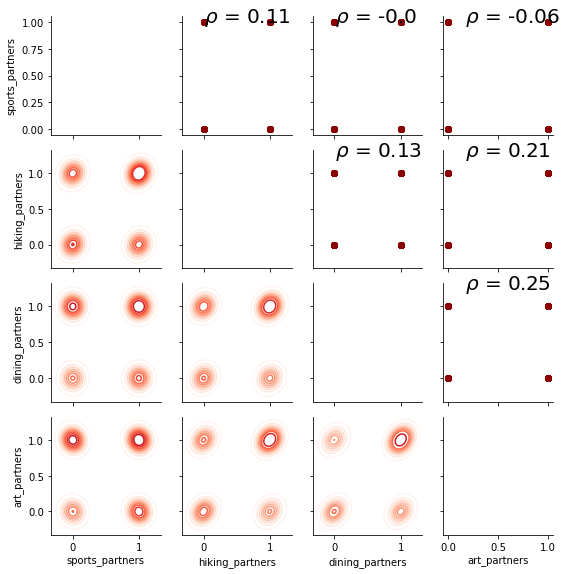

In [29]:
from scipy.stats import pearsonr
def corr(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]

    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)

# Create a pair grid instance
grid = sns.PairGrid(data= df_personal,
                    vars = [
                                'sports_partners','hiking_partners','dining_partners','art_partners'
                           ], size = 2)

# Map the plots to the locations
grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = 'darkred');